In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import os, yaml

# import plt
import matplotlib.pyplot as plt

# Iceland borders
world = gpd.read_file('https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip')
iceland = world[world['NAME'] == 'Iceland']

In [2]:
# Config
with open('download_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

START_DATE = config.get('date_range', {}).get('start_date', '2010-01-01')
LON_MIN = config.get('boundary_box', {}).get('lon_min', -30)
LON_MAX = config.get('boundary_box', {}).get('lon_max', -10)
LAT_MIN = config.get('boundary_box', {}).get('lat_min', 61)
LAT_MAX = config.get('boundary_box', {}).get('lat_max', 68)

DEPTH_THRESHOLD = -20 # meters
MIN_WEIGHT = 10 # filter out catches less than this weight (in kg)

SAVE_FIGS = True # Boolean if figures should be saved
FIG_DIR = 'figures'
# make figures directory if it doesn't exist
if not os.path.exists(FIG_DIR):
    os.makedirs(FIG_DIR)


In [3]:
df = pd.read_csv("rawdata/hafro_demersal.csv")
df.head()

,species,towtime,gear,latitude,longitude,depth,weight,date
0,LUM,NaN,GIL,0.0,0.0,10.9728,1700.0,2015-05-14 00:00:00+00:00
1,LUM,NaN,GIL,0.0,0.0,27.4320,3000.0,2015-04-20 00:00:00+00:00
2,COD,NaN,LLN,0.0,0.0,54.8640,2000.0,2013-02-25 00:00:00+00:00
3,PRA,219.0,SHT,0.0,0.0,148.1328,1000.0,2014-04-28 00:00:00+00:00
4,PRA,120.0,SHT,0.0,0.0,160.9344,100.0,2014-04-08 00:00:00+00:00


In [4]:
alpha3 = pd.read_csv("rawdata/ASFIS_sp_2025.csv")[["Alpha3_Code", "English_name"]]
print(alpha3.head())

# add english name to df
df_names = df.merge(alpha3, left_on="species", right_on="Alpha3_Code", how="left")
df_names = df_names.drop(columns=["Alpha3_Code"])

  Alpha3_Code         English_name
0         GXM  Siamese algae-eater
1         CDO     River carpsucker
2         FMP            Quillback
3         ATC      Longnose sucker
4         ATO         White sucker


Total number of species: 71
English_name
Atlantic cod                     3707314
Haddock                          2227295
Saithe(=Pollock)                 1302836
European plaice                   956265
Atlantic wolffish                 721822
Northern prawn                    640357
Ling                              442346
Common dab                        299742
Greenland halibut                 271148
Lemon sole                        247928
Norway lobster                    246353
Tusk(=Cusk)                       214372
Angler(=Monk)                     199064
Spotted wolffish                  181122
Witch flounder                    172792
Beaked redfish                    143288
Amer. plaice(=Long rough dab)     134019
Atlantic halibut                  102252
Whiting                            95356
Blue ling                          89405
Greater argentine                  57440
Megrim                             35096
Lumpfish(=Lumpsucker)              18978
Name: count, dty

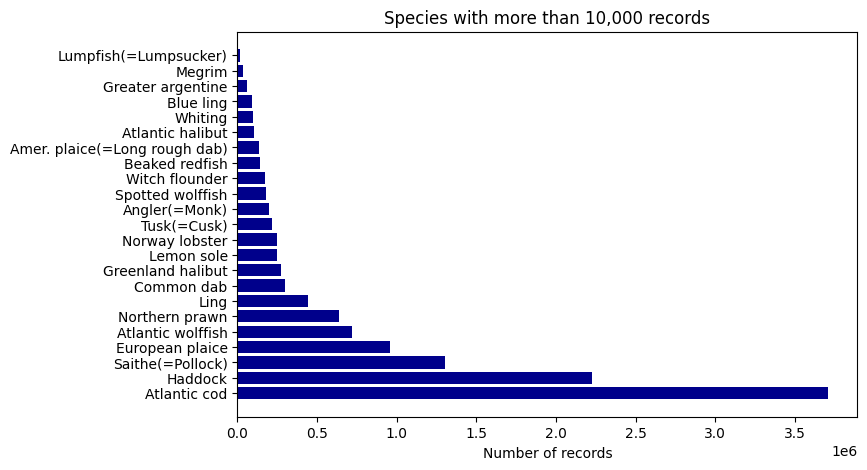

In [5]:
types = df_names['English_name'].value_counts()
print(f"Total number of species: {len(types)}")
types = types[types > 10000]
print(types, len(types))
plt.figure(figsize=(8,5))
plt.barh(types.index, types.values, color='darkblue')
plt.xlabel('Number of records')
plt.title('Species with more than 10,000 records')

# save figure
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, 'species_counts.pdf'), bbox_inches='tight')

In [6]:
# Make the date a daytime object
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S%z").dt.date
#d['year'] = pd.to_datetime(d['date']).dt.year

# Sort by date
#df = df.sort_values(by='date').reset_index(drop=True)

df.head()

,species,towtime,gear,latitude,longitude,depth,weight,date
0,LUM,NaN,GIL,0.0,0.0,10.9728,1700.0,2015-05-14
1,LUM,NaN,GIL,0.0,0.0,27.4320,3000.0,2015-04-20
2,COD,NaN,LLN,0.0,0.0,54.8640,2000.0,2013-02-25
3,PRA,219.0,SHT,0.0,0.0,148.1328,1000.0,2014-04-28
4,PRA,120.0,SHT,0.0,0.0,160.9344,100.0,2014-04-08


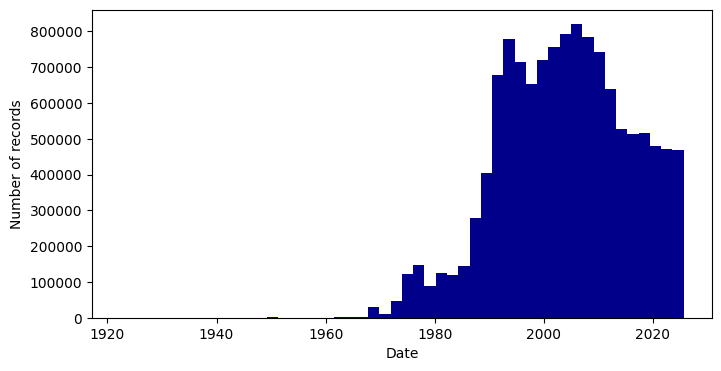

In [7]:
# histogram with date
plt.figure(figsize=(8,4))
plt.hist(pd.to_datetime(df['date']), bins=50, color='darkblue')
plt.xlabel('Date')
plt.ylabel('Number of records')
plt.show()

In [8]:
# Filter data after 2010
df = df[pd.to_datetime(df['date']) >= START_DATE]

# Filter out catches less than MIN_WEIGHT
d = df[df['weight'] >= MIN_WEIGHT]

# Filter area
ds = d[(d['longitude'] > LON_MIN) & (d['longitude'] < LON_MAX) & (d['latitude'] > LAT_MIN) & (d['latitude'] < LAT_MAX)]

len(ds)

3821781

<Axes: >

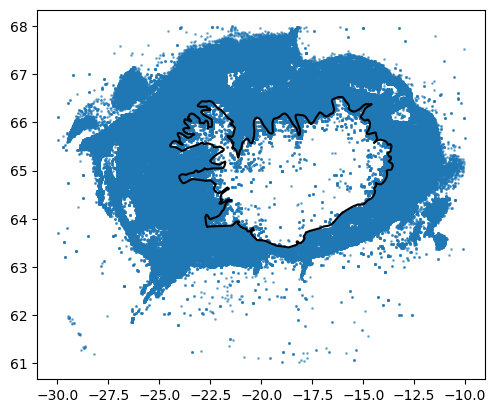

In [9]:
plt.scatter(ds['longitude'], ds['latitude'], s=1, alpha=0.5)
iceland.boundary.plot(ax=plt.gca(), color="black")


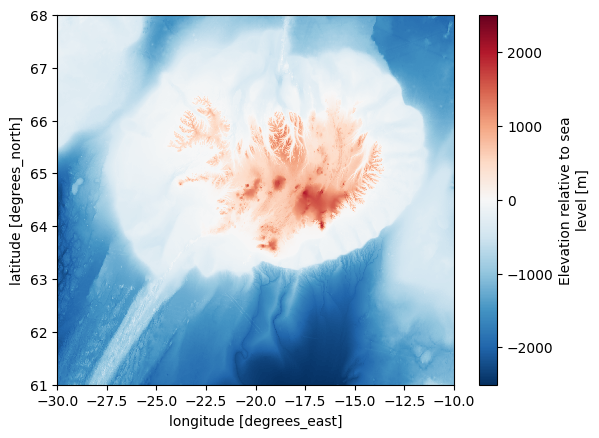

In [10]:
# Import bathymetry dataset
bathy = xr.open_dataset('rawdata/GEBCO_15_Oct_2025/gebco_2025_n68.0_s61.0_w-30.0_e-10.0.nc')

fig, ax = plt.subplots()
bathy.elevation.plot(ax=ax)
#iceland.boundary.plot(ax=ax, color='black')

In [11]:
# Filter by depth from the bathymetry
catch_elevation = bathy['elevation'].sel(
    lat=xr.DataArray(ds['latitude'], dims="points"),
    lon=xr.DataArray(ds['longitude'], dims="points"),
    method="nearest"
)

ds = ds[catch_elevation.values < DEPTH_THRESHOLD]

<Axes: >

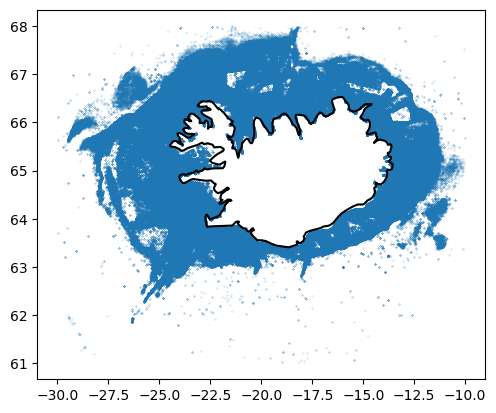

In [12]:
plt.scatter(ds['longitude'], ds['latitude'], s=0.05, alpha=0.5)
iceland.boundary.plot(ax=plt.gca(), color="black")

In [13]:
# group dss by the same latitude, longitude and date
grouped = ds.groupby(['latitude', 'longitude', 'date'], as_index=False).agg(list)

# Make gear the first element of the list (assuming all gear types are the same for a given haul)
grouped['gear'] = grouped['gear'].apply(lambda x: x[0])

In [14]:

grouped['pok_ratio'] = grouped.apply(
    lambda r: 0 if 'POK' not in r['species'] 
    else sum(w for s, w in zip(r['species'], r['weight']) if s == 'POK') / sum(r['weight']),
    axis=1
)
grouped['pok'] = (grouped['pok_ratio'] > 0).astype(int)

# compute the ratio of rows that have POK in their species list
# dss_grouped['has_POK'] = dss_grouped['species'].apply(lambda x: 'POK' in x)

print(f"Total hauls: {len(grouped)}")
print(f"Hauls with POK: {len(grouped[grouped['pok'] == 1])}")

Total hauls: 1191330
Hauls with POK: 423144


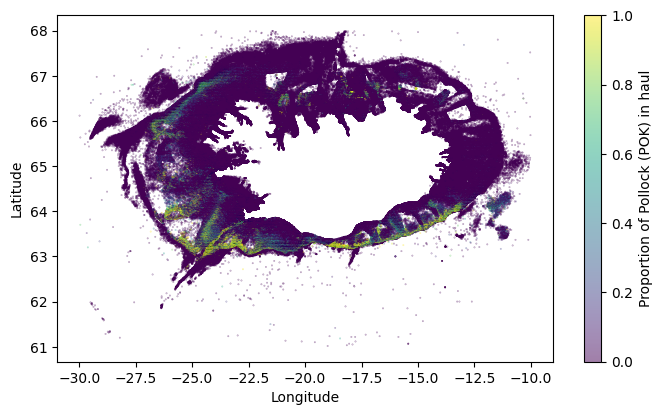

In [15]:
plt.figure(figsize=(8,4.5))
plt.scatter(grouped['longitude'], grouped['latitude'], s=0.1, alpha=0.5, c=grouped['pok_ratio'], cmap='viridis')
plt.colorbar(label='Proportion of Pollock (POK) in haul')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# save figure
if SAVE_FIGS:
    plt.savefig(os.path.join(FIG_DIR, 'pok_ratio_map.png'), dpi=150, bbox_inches='tight')

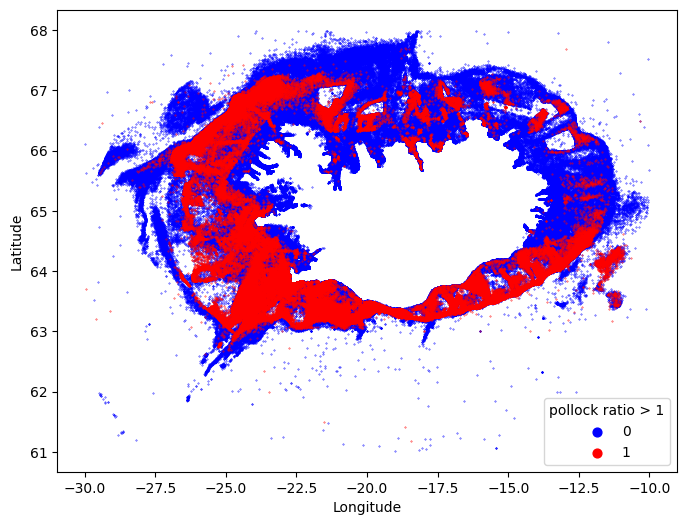

In [90]:
plt.figure(figsize=(8,6))
plt.scatter(
    grouped.loc[grouped['pok_ratio'] <= 0.1, 'longitude'],
    grouped.loc[grouped['pok_ratio'] <= 0.1, 'latitude'],
    s=0.1, color='blue', label='0'
)

plt.scatter(
    grouped.loc[grouped['pok_ratio'] > 0.1, 'longitude'],
    grouped.loc[grouped['pok_ratio'] > 0.1, 'latitude'],
    s=0.1, color='red', label='1'
)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='pollock ratio > 1', loc='best', markerscale=20)
plt.show()

# save figure
# if SAVE_FIGS:
#     plt.savefig(os.path.join(FIG_DIR, 'pok_ratio_map_binary.pdf'), bbox_inches='tight')

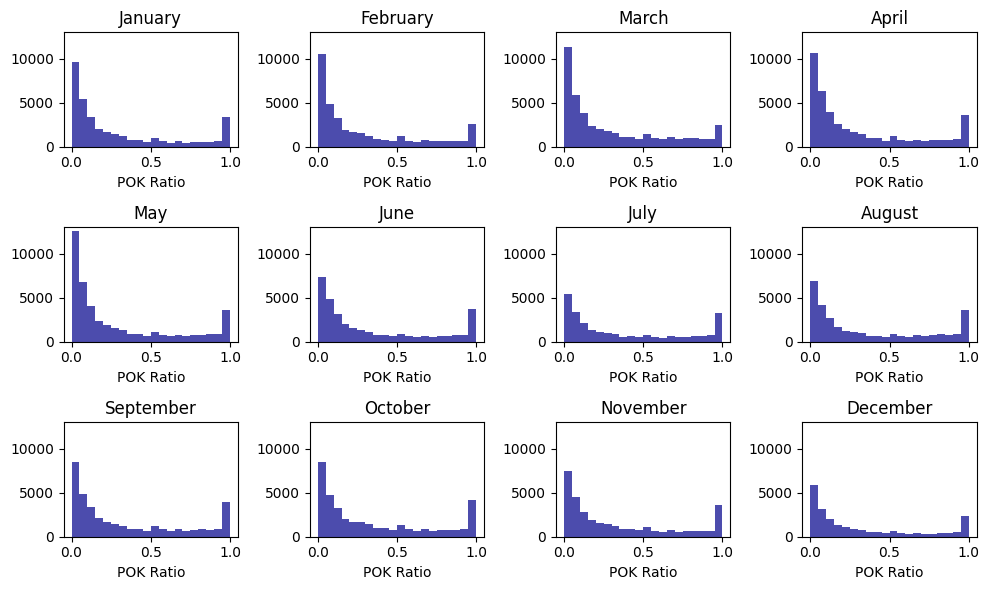

In [70]:
# plot histograms of pok_ratio for each month
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
          7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
plt.figure(figsize=(10,6))
for month in range(1, 13):
    plt.subplot(3, 4, month)
    monthly_data = grouped[(pd.to_datetime(grouped['date']).dt.month == month) & (grouped['pok_ratio'] > 0)]
    plt.hist(monthly_data['pok_ratio'], bins=20, range=(0,1), color='darkblue', alpha=0.7)
    plt.ylim(0, 13000)
    plt.title(months[month])
    plt.xlabel('POK Ratio')

plt.tight_layout()

In [37]:
grouped['date'] = pd.to_datetime(grouped['date'])
grouped = grouped.sort_values(by='date').reset_index(drop=True)

# remove depth and towtime column
if 'depth' in grouped.columns:
    grouped = grouped.drop(columns=['depth'])
if 'towtime' in grouped.columns:
    grouped = grouped.drop(columns=['towtime'])

# save to csv
grouped.to_csv('data/pok_2010_2025.csv', index=False)

grouped.head()

,latitude,longitude,date,species,gear,weight,pok_ratio,pok
0,65.0000,-24.1333,2010-01-01,"[HAD, COD]",LLN,"[2200.0, 200.0]",0.0,0
1,65.0667,-23.9000,2010-01-02,"[COD, HAD]",LLN,"[2000.0, 10000.0]",0.0,0
2,64.2500,-22.2500,2010-01-02,"[CAA, COD, HAD]",LLN,"[300.0, 1700.0, 800.0]",0.0,0
3,66.3500,-23.9667,2010-01-02,"[COD, HAD]",LLN,"[2300.0, 700.0]",0.0,0
4,66.0167,-21.0000,2010-01-02,"[HAD, CAS, COD]",LLN,"[3500.0, 10.0, 1700.0]",0.0,0


In [ ]:
# import cartopy.crs as ccrs
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()